Get usernames of all active users from each of 12 subreddits  
02/22/23  
[0]: # Path: recovery-network/get_data.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
# do not print warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
dat_path = "/Users/laylabouzoubaa/Library/CloudStorage/OneDrive-DrexelUniversity/Social_NLP_Lab/Datasets/Reddit Drug Data- RAW - DNT/Central/data Dec 1st 2022/data 2018_1_1 to 2022_7_30_"
subreddits = ["opiates", "benzodiazepines", "stims", "MDMA", "cannabis", "Psychedelics", "LSD", "shrooms", "cocaine", "Autoflowers", "ambien"]


In [3]:
drug_info = ["Autoflowers"]
seek_exp = []
cont_use = ["ambien", "opiates", "cocaine", "benzodiazepines", "stims", "shrooms", "LSD", "cannabis", "Psychedelics"]
stop_use = []
harm_red = ["MDMA"]
misc = []

In [4]:
# get redditor info for each subreddit
users = pd.DataFrame()
for subreddit in subreddits:
    print(subreddit)
    try:
        df = pd.read_json(dat_path + subreddit + "_redditor.json", lines=True)
        df = df[1][0]
        df = pd.DataFrame(df)
        df["subreddit"] = subreddit
        if subreddit in cont_use:
            df["type"] = "IS_continue_use"
        elif subreddit in drug_info:
            df["type"] = "Drug_info"
        elif subreddit in harm_red:
            df["type"] = "Harm_reduction"
        # append to users
        users = users.append(df)
    except:
        print("No redditor data for " + subreddit)

opiates
benzodiazepines
stims
MDMA
cannabis
Psychedelics
LSD
shrooms
cocaine
Autoflowers
ambien


### Bot filtering

'Bot' in the name

In [5]:
# remove users with  "-bot" in their name
# users 974,309 rows
bot_patterns = ["-bot", "AutoModerator", "Bot", "BOT", "B0T", "b0t", "b0T", "bOt", "_bot"]
users = users[~users["name"].str.contains('|'.join(bot_patterns))]
# now 972,393 rows

Extremely high post and comment karma or extremely negative karma

- sometimes the post and comment karma are the same, which is suspicious

In [6]:
# calculate the total karma
users["total_karma"] = users["comment_karma"] + users["post_karma"]

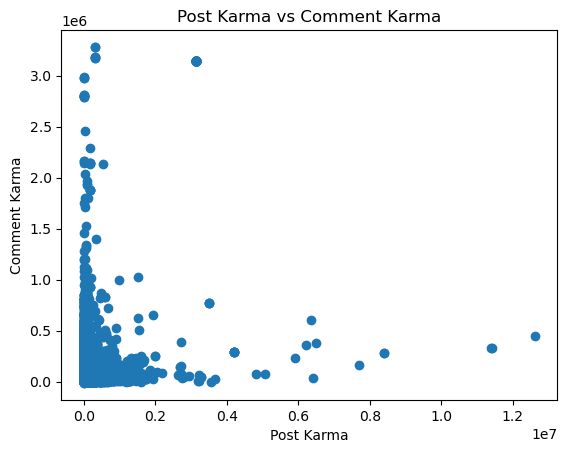

In [7]:
# scatter plot of post karma vs comment karma
plt.scatter(users["post_karma"], users["comment_karma"])
plt.xlabel("Post Karma")
plt.ylabel("Comment Karma")
plt.title("Post Karma vs Comment Karma")
plt.show()

Accounts with negative total karma are likely to be bots

In [8]:
# remove accounts with negative total karma
users = users[users["total_karma"] > 0]
# now 911,260 rows

In [9]:
# calculate the outlier cutoff
# calculate interquartile range
q25, q75 = np.percentile(users["total_karma"], 25), np.percentile(users["total_karma"], 75)
iqr = q75 - q25
# calculate the outlier cutoff
cut_off = iqr * 1.5
lower, upper = q25 - cut_off, q75 + cut_off
# identify outliers
outliers = [x for x in users["total_karma"] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))

Identified outliers: 125778


People with 0 post and comment karma are likely legitimate users but are lurkers and thus not useful for our purposes

In [10]:
# remove outliers
users = users[users["post_karma"] < upper]

users = users[users["post_karma"] > lower]
# now 870,764 rows


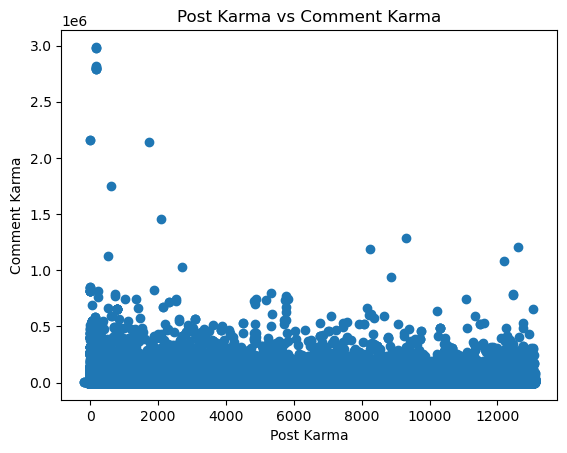

In [11]:
# plot again
plt.scatter(users["post_karma"], users["comment_karma"])
plt.xlabel("Post Karma")
plt.ylabel("Comment Karma")
plt.title("Post Karma vs Comment Karma")
plt.show()

---
### Get Metadata

In [16]:
# get metadata for each user
import praw
from pmaw import PushshiftAPI

# source api credentials from file
file = 'py/api-creds.py'
exec(open(file).read())


In [21]:
# set the multithreading parameter to 20
# the number of processers on my computer times 5
import os
num_processors = os.cpu_count()
print(num_processors)
num_threads = num_processors * 5

10


In [23]:
# set num_workers to num_threads for PMAW
api = PushshiftAPI(num_workers = 50, praw = reddit)

In [64]:
user_subreddits = []
for user in users["name"]:
    try:
        user_dat = []
        redditor = reddit.redditor(user)
        for subreddit in redditor.submissions.top(limit=None):
            user_dat.append(subreddit.subreddit.display_name)
        user_dat = list(set(user_dat))
        user_subreddits.append(user_dat)
    except:
        user_subreddits.append(None)


In [57]:
blah2 = []
for subreddit in redditor.submissions.top(limit=None):
    x = subreddit.subreddit.display_name
    # print the unique subreddit names
    blah2.append(x)
list(set(blah2))

['Diablo',
 'self',
 'researchchemicals',
 'audiobooks',
 'sniperelite5',
 'AskDocs',
 'Drugs',
 'goldwing',
 'FoodPorn',
 'javascript',
 'motorcycles',
 'aww',
 'opiates',
 'webdev',
 'keto',
 'vstar',
 'Coronavirus',
 'medical',
 'cardano',
 'DrugNerds',
 'ada_meme',
 'cakeday',
 'Triumph',
 'Frontend',
 'ChronicPain',
 'learnjavascript',
 'KeybaseProofs',
 'gatsbyjs',
 'Harley',
 'CoronaVirusTX',
 'shortwave',
 'JoeRogan',
 'VOIP',
 'SuggestAMotorcycle',
 'web_design',
 'Vue',
 'reactjs',
 'Motorrad',
 'backpain',
 'Next']

In [44]:
# get names of subreddits
blah2[1].display_name

'EnoughTrumpSpam'

In [30]:
# top 100 of all time submissions

for submission in redditor.submissions.top('all'):
    print(submission.subreddit)

/var/folders/jj/bt0ykz9n5_16z2gvbybl0tbc0000gn/T/ipykernel_12614/1338652586.py:3: DeprecationWarning: Positional arguments for 'BaseListingMixin.top' will no longer be supported in PRAW 8.
Call this function with 'time_filter' as a keyword argument.
  for submission in redditor.submissions.top('all'):


politics
science
pics
u_BlankVerse
nottheonion
politics
worldnews
worldnews
politics
news
worldnews
nottheonion
politics
news
politics
politics
politics
news
news
politics
Coronavirus
UpliftingNews
worldnews
worldnews
politics
politics
politics
worldnews
pics
politics
worldnews
politics
politics
news
Economics
politics
politics
politics
politics
byebyejob
entertainment
books
science
politics
news
UpliftingNews
worldnews
news
politics
politics
Coronavirus
politics
EverythingScience
news
UpliftingNews
television
UpliftingNews
politics
news
news
sports
politics
atheism
Impeach_Trump
politics
UpliftingNews
books
Coronavirus
news
UpliftingNews
politics
politics
worldnews
politics
Coronavirus
Impeach_Trump
worldnews
space
politics
atheism
UpliftingNews
news
sports
Coronavirus
Coronavirus
politics
UpliftingNews
Impeach_Trump
space
politics
politics
politics
EnoughTrumpSpam
news
politics
politics
politics
Coronavirus
Coronavirus
politics
